In [37]:
from keras import __version__
import numpy as np
from keras.models import model_from_json, Model, Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from keras import optimizers
from sklearn.model_selection import train_test_split
import keras
from tempfile import TemporaryFile
import random
import csv
from sklearn.neighbors import KDTree
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_clothing_classifier():
    weights_path = 'inceptionv3_clothing_expanded_classifier.h5'
    json_path = 'incep_filter_clothing_expanded_classifier.json'

    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    return loaded_model

def get_clothing_vector_model():
    loaded_model = get_clothing_classifier()
    loaded_model.layers.pop() # Get rid of the classification layer
    last = loaded_model.layers[-1].output
    model = Model(loaded_model.input, last)
    return model

def image_preprocess(img_path):
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) however we need to expand the
    # dimension by making the shape (1, inputShape[0], inputShape[1], 3)
    # so we can pass it through thenetwork
    image = np.expand_dims(image, axis=0)

    # pre-process the image using the appropriate function based on the
    # model that has been loaded (i.e., mean subtraction, scaling, etc.)
    image = preprocess_input(image)
    return image

def get_classier_prediction(clothing_classifier, img_path):
    clothes_labels = ['dresses', 'handbags', 'hats', 'jackets', 'jeans', 
                      'jewelry', 'shorts', 'skirts', 'sunglasses', 'sweaters', 
                      'sweatshirts', 'womens-outerwear', 'womens-pants', 'womens-shoes', 'womens-tops']
    img = image_preprocess(img_path)
    preds = clothing_classifier.predict(img)[0]
    preds_labels = list(zip(clothes_labels, preds))
    preds_labels.sort(key=lambda p: p[1], reverse=True)
    return preds_labels

In [3]:
clothing_classifier = get_clothing_classifier()
clothing_classifier.summary()

Loaded model from disk
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_234 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_233 (BatchNo (None, None, None, 32 96          conv2d_234[0][0]                 
____________________________________________________________________________________________________
activation_233 (Activation)      (None, None, None, 32 0           batch_normalization_233[0][0]    
____________________________________________________________________

____________________________________________________________________________________________________


In [ ]:
jeans_img_path = 'data-all/validation/jeans/482888849.jpg'
dress_img_path = 'data-all/validation/dresses/535993294.jpg'
jackets_img_path = 'data-all/validation/jackets/614521319.jpg'
jackets_img_path2 = 'data-all/validation/jackets/614763686.jpg'
sunglasses_img_path = 'data-all/validation/sunglasses/655241570.jpg'
dog_img_path = 'data-pets/train/dogs/dog.0.jpg'
get_classier_prediction(clothing_classifier, jeans_img_path)

In [ ]:
classifier_vector_model = get_clothing_vector_model()
img_jacket = image_preprocess(jackets_img_path)
img_jacket2 = image_preprocess(jackets_img_path2)
img_jeans = image_preprocess(jeans_img_path)
img_dress = image_preprocess(dress_img_path)
img_dog = image_preprocess(dog_img_path)

jacket_feat = classifier_vector_model.predict(img_jacket)
jacket_feat2 = classifier_vector_model.predict(img_jacket2)
jeans_feat = classifier_vector_model.predict(img_jeans)
dress_feat = classifier_vector_model.predict(img_dress)
dog_feat = classifier_vector_model.predict(img_dog)

jacket_feat

In [ ]:
# compare cosine similarities
print('2 jackets: ', cosine_similarity(jacket_feat, jacket_feat2))
print('jeans and dress: ', cosine_similarity(jeans_feat, dress_feat))
print('jeans and dog: ', cosine_similarity(jeans_feat, dog_feat))

In [ ]:
jacket_feat.shape # (1, 1024)

## Skipgrams Model

In [8]:
def save_product_features(model, product_file, img_dir, output_file):
    products = []
    print('Reading file ', product_file)
    with open(product_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:]):
            if i % 50 == 0:
                print('Processing product ', i)
            try:
                l = line.split('\t')
                product_id = l[0]
                product_img_path = img_dir + product_id + '.jpg' 
                product_img = image_preprocess(product_img_path)
                product_feat = model.predict(product_img)
    
                products.append([product_id] + product_feat[0].tolist())
            except Exception as e:
                print(e)
                
    print('Saving products to ', output_file)
    with open(output_file, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        for p in products:
            writer.writerow(p)
            f.flush()
    return products

def get_product_permutation_inputs(outfit_permutations_file, product_to_features):
    outfit_features = [] # each row = X, y, id
    print('Reading file ', outfit_permutations_file)
    with open(outfit_permutations_file, 'r') as f:
        for line in f:
            try:
                l = line.split()
                product1_id = l[2]
                product2_id = l[5]
                product3_id = l[8]
                product4_id = l[11]
                
                X_products = [(product1_id, l[3]), (product2_id, l[6]), (product3_id, l[9])]
                y_product = (product4_id, l[12])
                
                product1_feat = product_to_features[product1_id]
                product2_feat = product_to_features[product2_id]
                product3_feat = product_to_features[product3_id]
                product4_feat = product_to_features[product4_id]
                
                merged_feat = np.concatenate((product1_feat, product2_feat, product3_feat), axis=1)
                # outfit_features.append((merged_feat, y_output, outfit_id))
                outfit_features.append([merged_feat, product4_feat, 
                                        X_products, y_product])
            except Exception as e:
                print(e)
    random.shuffle(outfit_features)
    
    X = []
    y = []
    X_products = []
    y_products = []
    for outfit in outfit_features:
        X.append(outfit[0])
        y.append(outfit[1])
        X_products.append(outfit[2])
        y_products.append(outfit[3])
    return np.array(X), np.array(y), X_products, y_products

def get_product_to_features(product_feats_file):
    product_to_feats = {}
    with open(product_feats_file, 'r') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        for row in tsvreader:
            product_id = row[0]
            feats = np.array([[float(n) for n in row[1:]]])
            product_to_feats[product_id] = feats
    return product_to_feats

In [ ]:
# Run one time to save product weights
# save_product_features(classifier_vector_model, 'data-outfits/outfit_products.tsv', 
#                       'data-outfits/images/', 'data-outfits/outfit_product_features.tsv')

In [5]:
product_feats_file = 'data-outfits/outfit_product_features.tsv'
outfit_permutations_file = 'data-outfits/outfit_permutations.tsv'
prods_to_feats = get_product_to_features(product_feats_file)
prods_to_feats['615752261']

array([[ 0.42040107,  1.48408139,  0.11978239, ...,  2.25705886,
         0.37974471,  0.94305986]])

In [9]:
outfit_permutations_file_temp = 'data-outfits/outfit_permutations_temp.tsv'
(X, y, X_products, y_products) = get_product_permutation_inputs(outfit_permutations_file_temp, prods_to_feats)

Reading file  data-outfits/outfit_permutations_temp.tsv


In [10]:
np.array(X).shape # (400, 1, 2048)

(20000, 1, 3072)

In [11]:
def make_skipgrams_clothing_model():
    seq = Sequential()
    # seq.add(Dense(128, input_shape=(1,2048), activation='relu', name='fc1'))
    seq.add(Dense(1024, input_shape=(1,3072), activation='relu', name='fc1'))
    seq.add(Dropout(0.2))
    seq.add(Dense(256, activation='relu', name='fc2'))
    seq.add(Dropout(0.1))
    #seq.add(Flatten())
    seq.add(Dense(1024, activation='softmax', name='fc_final'))
    seq.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=0.00001), metrics=["accuracy"])
    return seq

In [13]:
clothing_skipgrams_model = make_skipgrams_clothing_model()
clothing_skipgrams_model.summary()
clothing_skipgrams_model.fit(X, y, validation_split=0.3, epochs=15, batch_size=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1, 1024)           3146752   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1024)           0         
_________________________________________________________________
fc2 (Dense)                  (None, 1, 256)            262400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
fc_final (Dense)             (None, 1, 1024)           263168    
Total params: 3,672,320
Trainable params: 3,672,320
Non-trainable params: 0
_________________________________________________________________
Train on 14000 samples, validate on 6000 samples
Epoch 1/15
14000/14000 [==============================] - 17s - loss: 9977.1586 - a

In [22]:
def get_prod_feat_list():
    index_to_prod = {}
    prod_features = []
    for i, prod_feat in enumerate(prods_to_feats.items()):
        prod_id, feat = prod_feat
        index_to_prod[i] = prod_id
        prod_features.append(feat[0])
    return index_to_prod, np.array(prod_features)
        
index_to_prod, prod_features = get_prod_feat_list()

In [23]:
prod_features[:3]

array([[ 0.        ,  5.85957146,  1.24812102, ...,  6.95872259,
         1.77266467,  3.18993473],
       [ 0.38827777,  3.8499105 ,  0.56135225, ...,  5.08135939,
         1.19380879,  2.65321469],
       [ 0.53009707,  3.31409311,  0.47977686, ...,  5.19207239,
         2.10588574,  2.59770107]])

In [25]:
productTree = KDTree(prod_features, leaf_size=50)

In [35]:
def get_closest_product_ids(input_features, tree, index_to_prod_mapping):
    results = tree.query(input_features, k=5, return_distance=False)[0]
    return [index_to_prod_mapping[index] for index in results]

In [29]:
clothing_predictions = list(zip(X_products, clothing_skipgrams_model.predict(X)))
clothing_predictions[:3]

[([('655400138', 'womens-shoes'),
   ('656248323', 'womens-tops'),
   ('603515309', 'jewelry')],
  array([[ 0.00021356,  0.00167341,  0.00021331, ...,  0.00221833,
           0.00067997,  0.00121402]], dtype=float32)),
 ([('651567247', 'handbags'),
   ('615019037', 'womens-shoes'),
   ('642019713', 'jewelry')],
  array([[ 0.00021086,  0.00177013,  0.00027097, ...,  0.0022114 ,
           0.00072904,  0.00116235]], dtype=float32)),
 ([('621042660', 'womens-tops'),
   ('497773465', 'jeans'),
   ('519835627', 'hats')],
  array([[ 0.00020679,  0.00182413,  0.00027949, ...,  0.00246165,
           0.00074005,  0.00123582]], dtype=float32))]

In [49]:
def display_product_images(product_ids):
    image_count = len(product_ids)
    fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
    
    for i, product_id in enumerate(product_ids):
        image_file = 'data-outfits/images/' + product_id + '.jpg'
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        ax[i].imshow(image, interpolation='nearest')
        ax[i].axis("off")
    plt.show()

0 Input Products: ['655400138', '656248323', '603515309']


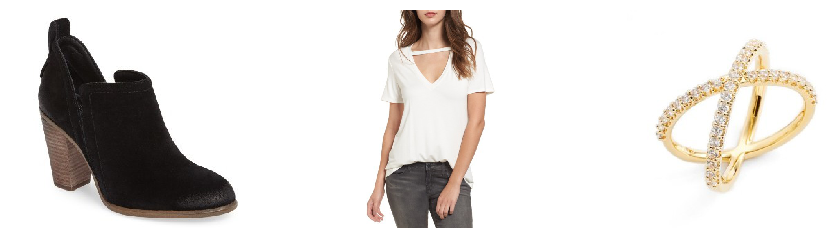

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']
0 Input Products: ['612712533', '656260753', '485129799', '616386608', '625027516']
1 Input Products: ['651567247', '615019037', '642019713']


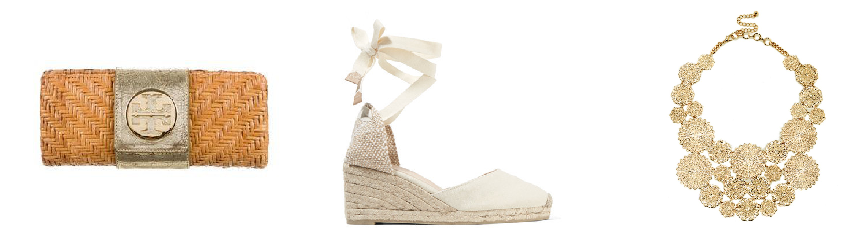

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']
1 Input Products: ['612712533', '656260753', '485129799', '616386608', '625027516']
2 Input Products: ['621042660', '497773465', '519835627']


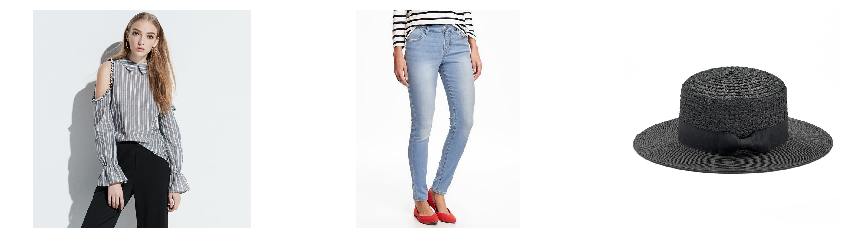

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']
2 Input Products: ['612712533', '656260753', '485129799', '616386608', '625027516']
3 Input Products: ['531383393', '25237', '525141975']


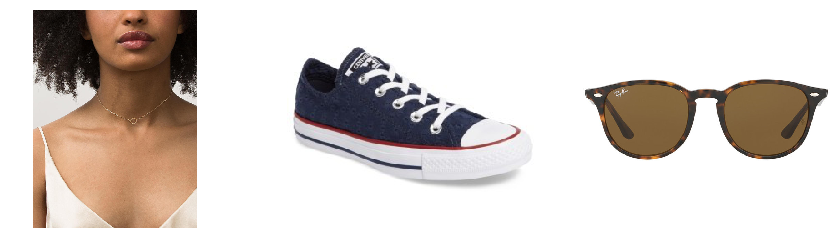

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']
3 Input Products: ['612712533', '656260753', '485129799', '616386608', '625027516']
4 Input Products: ['602756480', '621773875', '529004951']


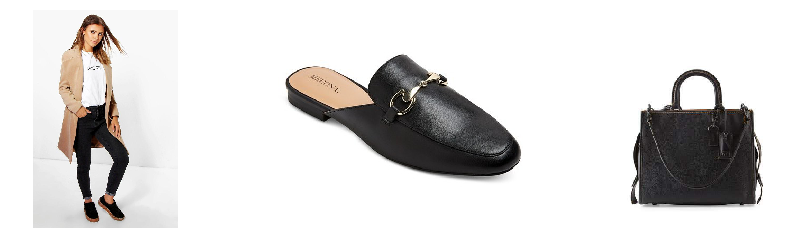

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']
4 Input Products: ['612712533', '656260753', '485129799', '616386608', '625027516']
5 Input Products: ['631877203', '638190334', '631877271']


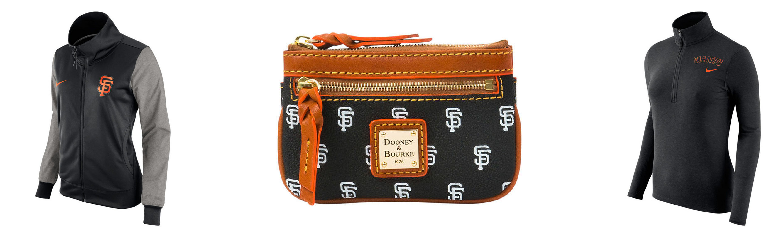

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']
5 Input Products: ['612712533', '656260753', '485129799', '616386608', '625027516']
6 Input Products: ['658709148', '513127982', '505608746']


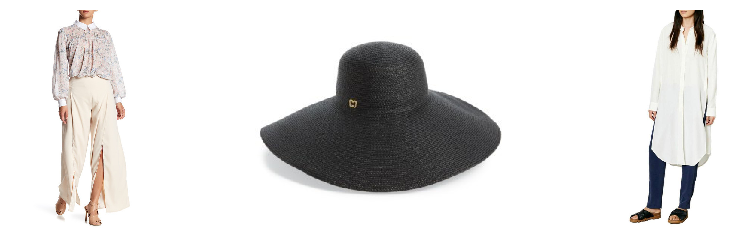

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']
6 Input Products: ['612712533', '656260753', '485129799', '616386608', '625027516']
7 Input Products: ['630460343', '626680676', '636867358']


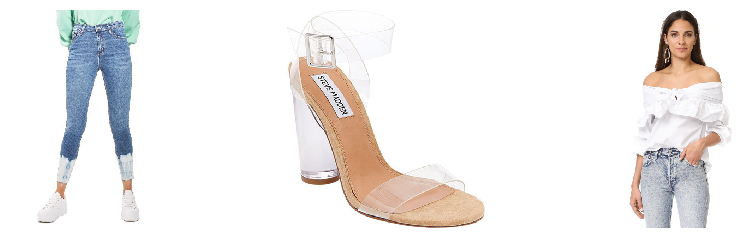

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']
7 Input Products: ['612712533', '656260753', '485129799', '616386608', '625027516']
8 Input Products: ['632813810', '536686362', '621817710']


KeyboardInterrupt: 

In [51]:
for i, pred in enumerate(clothing_predictions[:15]):
    X_products, prediction_vector = pred 
    X_product_ids = [p[0] for p in X_products] 
    print('{} Input Products: {}'.format(i, X_product_ids))
    display_product_images(X_product_ids)
    closest_product_ids = get_closest_product_ids(prediction_vector, productTree, index_to_prod)
    print('Closest products: {}'.format(closest_product_ids))
    display_product_images(closest_product_ids)

In [ ]:
a = np.array([[1,2, 3]])
b = np.array([[4,5, 6]])
ab = np.concatenate((a, b, a), axis=1)
ab[0]

In [ ]:
ab.shape

In [ ]:
keras.utils.np_utils.to_categorical(np.array([1, 0, 0, 0]), num_classes=2)

In [ ]:
c = np.array([[0]])
np.concatenate((c, a), axis=1)

In [ ]:
d = np.array([1, 2, 3, 4])
np.array([0]) + d